In [39]:
%matplotlib inline
import scipy as sc
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import pystan

# Estimating FGO 5* 10-roll probabilities based on ~40k observations

(0.0, 0.95126999999999995, 62.5, 4937.5)

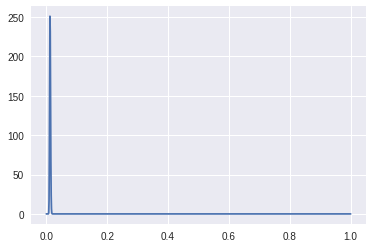

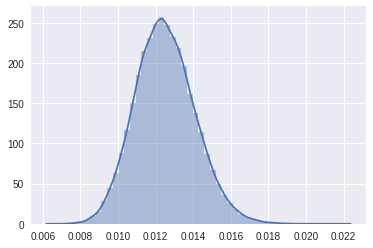

In [40]:
a0=1.25
b0=100-a0
p=50
a0*=p
b0*=p
prob = sc.stats.beta(a0,b0)
x=sc.linspace(0,1,1000)
y=prob.pdf(x)
plt.plot(x,y)
plt.figure()
sns.distplot(prob.rvs(100000))
sc.mean(prob.rvs(100000)<.001),sc.mean(prob.rvs(100000)>.01), a0,b0

# Data

In [41]:
a=406
aru=274
b=39431

# 5* 10-roll pull rate

Comparing effect of weak and strong priors

In [42]:
a0=1.25*50
b0=100*50-a0
prob=sc.stats.beta(a+a0,b-a+b0)
prob2=sc.stats.beta(a+1,b-a+1)

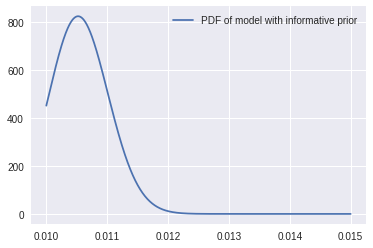

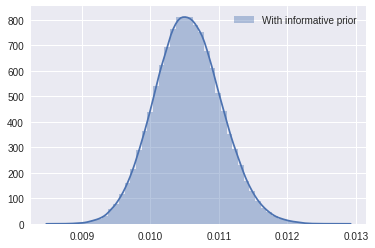

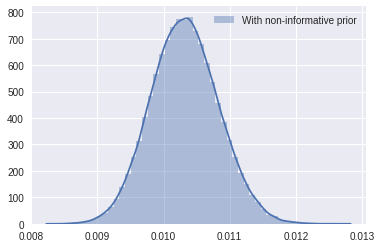

In [43]:
x=sc.linspace(.01,.015,1000)
y=prob.pdf(x)
plt.plot(x,y, label='PDF of model with informative prior')
plt.legend()
plt.figure()
sns.distplot(prob.rvs(100000), label='With informative prior')
plt.legend()
plt.figure()
sns.distplot(prob2.rvs(100000), label='With non-informative prior')
plt.legend()

### Model with strong informative prior

In [44]:
prob.mean()

0.010544439693007135

In [45]:
minp, maxp = prob.interval(.95)
f'Credible interval: {minp,maxp}, width of the interval: {maxp-minp}' 

'Credible interval: (0.0096157294630187379, 0.01151487942952778), width of the interval: 0.0018991499665090422'

### Model with uninformative prior

In [46]:
prob2.mean()

0.010321304491162225

In [47]:
minp, maxp = prob2.interval(.95)
f'Credible interval: {minp,maxp}, width of the interval: {maxp-minp}' 

'Credible interval: (0.0093475050250999368, 0.011342142917150744), width of the interval: 0.001994637892050807'

% difference in means

In [48]:
(prob.mean()-prob2.mean())*100

0.022313520184490988

## Stan test

Similar model estimated in Stan with additional prior information and non-beta prior distribution

In [49]:
model_code="""
data {
    int<lower=0> N1;
    int<lower=0> y1;
}
parameters {
    real<lower=0> theta1;
}
model {
    theta1 ~ normal(0.0125,0.0025);
    y1 ~ binomial(N1,theta1);
}
generated quantities {
}
"""
#theta1 ~ beta(1,1);
sm = pystan.StanModel(model_code=model_code)
fit = sm.sampling(data=dict(
    N1=b,
    y1=a,
))
samples = fit.extract(permuted=True)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc8ee1b0b67f5094c8b3081fb54ba14b NOW.


Inference for Stan model: anon_model_cc8ee1b0b67f5094c8b3081fb54ba14b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta1   0.01  1.1e-5 3.8e-4   0.01   0.01   0.01   0.01   0.01   1114    nan
lp__    -2269    0.04   0.85  -2272  -2270  -2269  -2269  -2269    506   1.01

Samples were drawn using NUTS at Thu Nov  2 21:13:09 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

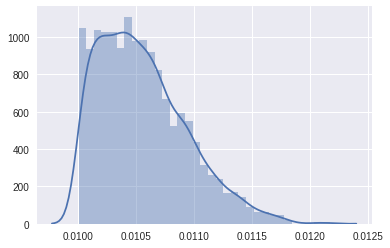

In [50]:
sns.distplot(samples['theta1'])

In [51]:
theta = samples['theta1']

In [52]:
theta.mean()

0.01055269260254682

In [53]:
stheta = sorted(samples['theta1'])
m=len(stheta)
r=int(sc.ceil(m*.95))
hdis=[(stheta[i],stheta[i+r]) for i in range(m-r)]
hdi=min(hdis, key=lambda x: abs(x[0]-x[1]))
hdi[0],hdi[-1]

(0.010002867448355894, 0.011274384286918624)

# Simulation

Trying to simulated the system

In [54]:
def map_items(n):
    intervals = (0,.01,.03,.4,.04,.12,.4)
    items = ('ssr-s','sr-s','r-s','ssr-c','sr-c','r-c')
    for i,_ in enumerate(intervals):
        if sum(intervals[:i])<n<sum(intervals[:i+1]):
            return items[i-1]
rdn=[[map_items(x) for x in sc.rand(10)] for y in range(1000000)]

In [55]:
def check_valid(m):
    for x in m:
        if 'sr' in x:
            break
    else:
        return False
    for x in m:
        if 'r-c' in x:
            break
    else:
        return False
    return True

In [56]:
valids=[x for x in rdn if check_valid(x)]

In [57]:
sc.mean(['ssr-s' in x for x in valids])/10

0.010719163998883957

In [58]:
len(valids)

892439

In [59]:
an=sc.sum(['ssr-s' in x for x in valids])/10
n=len(valids)

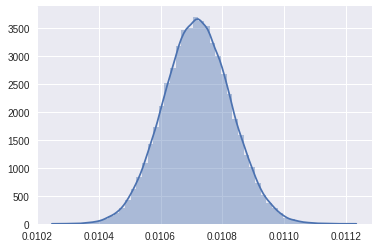

In [60]:
sns.distplot(sc.stats.beta(an,n-an).rvs(100000))

In [61]:
interval=sc.stats.beta(an,n-an).interval(.95)

In [62]:
f'Credible interval: {interval}, width of the interval: {interval[1]-interval[0]}' 

'Credible interval: (0.010506556493368669, 0.010933848600719775), width of the interval: 0.0004272921073511064'

(1.0168739893184804, 0.0072671386313949192)

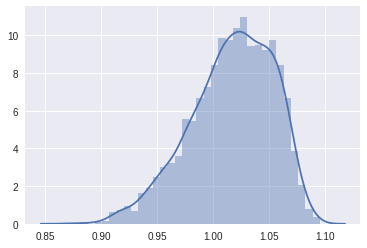

In [63]:
posterior_ratio = sc.stats.beta(an,n-an).rvs(4000)/theta
sns.distplot(posterior_ratio)
sc.mean(posterior_ratio), sc.log10(sc.mean(posterior_ratio))

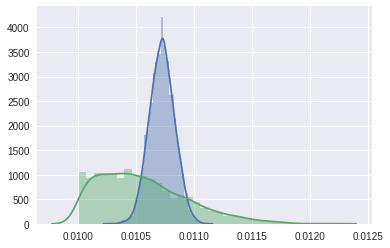

In [64]:
sns.distplot(sc.stats.beta(an,n-an).rvs(4000))
sns.distplot(theta)

# 5* 10-roll rate-up pull rate

Within 5\* pulls what is the probability of rate-up servants

In [65]:
a0=1
b0=1
probr = sc.stats.beta(aru+a0,a-aru+b0)

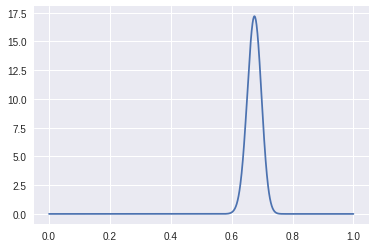

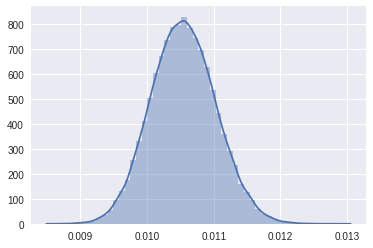

In [66]:
x=sc.linspace(0,1,1000)
y=probr.pdf(x)
plt.plot(x,y)
plt.figure()
sns.distplot(prob.rvs(100000))

In [67]:
minp, maxp = probr.interval(.95)
f'Credible interval: {minp,maxp}, width of the interval: {maxp-minp}' 

'Credible interval: (0.62781307126226904, 0.71861016491210372), width of the interval: 0.09079709364983468'

## Stan test

Same done in Stan

In [68]:
model_code="""
data {
    int<lower=0> N1;
    int<lower=0> y1;
}
parameters {
    real<lower=0> theta1;
}
model {
    y1 ~ binomial(N1,theta1);
}
generated quantities {
}
"""
#theta1 ~ beta(1,1);
sm = pystan.StanModel(model_code=model_code)
fit = sm.sampling(data=dict(
    N1=a,
    y1=aru,
))
samples = fit.extract(permuted=True)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fd71fe796d51e0aa2870c934bf0e01ec NOW.


Inference for Stan model: anon_model_fd71fe796d51e0aa2870c934bf0e01ec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta1   0.68  6.0e-4   0.02   0.63   0.66   0.68   0.69   0.72   1554    1.0
lp__   -256.9    0.02   0.75 -259.0 -257.1 -256.6 -256.4 -256.4   1900    1.0

Samples were drawn using NUTS at Thu Nov  2 21:16:11 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [69]:
thetar = samples['theta1']

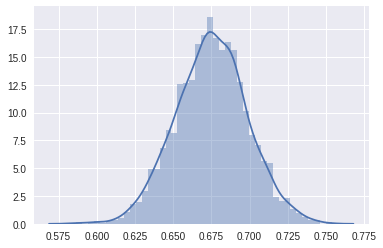

In [70]:
sns.distplot(thetar)

In [71]:
thetar.mean()

0.6750864315725349

In [72]:
stheta = sorted(thetar)
m=len(stheta)
r=int(sc.ceil(m*.95))
hdis=[(stheta[i],stheta[i+r]) for i in range(m-r)]
hdi=min(hdis, key=lambda x: abs(x[0]-x[1]))
hdi[0],hdi[-1]

(0.62544639963506221, 0.71856674689288169)

(0.012500000000000001, 0.0024999999999999988)

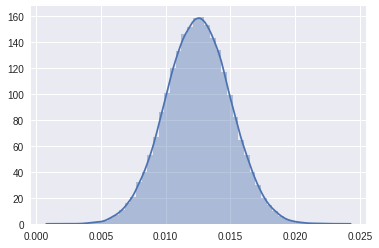

In [80]:
r=[0.01,0.015]
sns.distplot(sc.stats.norm(sc.mean(r), (r[1]-sc.mean(r))).rvs(100000))
sc.mean(r),r[1]-sc.mean(r)
